A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

![what-is-a-decision-tree](what-is-a-decision-tree.png)

The fundamental logic behind decision tree is that by dividing the data set into two and training the same model separately, the sum of loss is smaller than training the same model on the total data set.

Suppose we have a model that is trained by minimizing the following loss function:
$$
\mathcal{L}=l(\{\hat{y}_i\},\{y_i\}),
$$
e.g., $\mathcal{L}=\frac{1}{N}\sum_{i=1}^{N}(\hat{y}_i-y_i)^2$.

Here and after, we assume the loss function has the property that it is invariant under copying the training data set .e.g. the mean squared error.

Instead of training the model with all the data set, we can also divide the training data into two parts according to some condition: $\{y_i\}_1$ and $\{y_i\}_2$, then train the same model seperately on this two subsets. Two loss functions are then given by
\begin{align}
\mathcal{L}_1=&l(\{\hat{y}_i\}_1,\{y_i\}_1),\\
\mathcal{L}_2=&l(\{\hat{y}_i\}_2,\{y_i\}_2).
\end{align}
Then the average loss in most cases is smaller than the total loss
$$
\mathcal{L}_1 \frac{N_1}{N} + \mathcal{L}_2 \frac{N_2}{N}\leq \mathcal{L}
$$

The reason is that if the two subsets obey the same distribution, then the average loss is the same as the total loss. However, when there is significant discrepancy between the two subsets, it is possible the model **can detect this discrepancy** and adapt to two different models either of which fits better on its own subset and worse on the other subset. As a result, the average loss is smaller than the total. Of course, this reasoning relies on the assumptions that the bias of the model fist the subset and the discrepancy falls into the range of variance of the model. 

Here we give an example. Consider the model to be linear regression with  the loss function given by the mean square error, we divide a data sample of size $M+N$  into two subsets with size $M$ and $N$ respectively. In this picture:

In [77]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

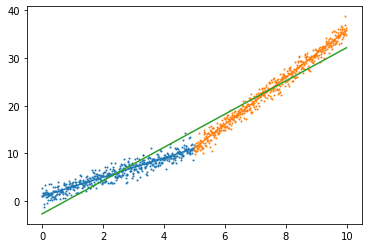

In [78]:
X_1=np.arange(0,5,0.01)
X_1=np.expand_dims(X_1,axis=1)
Y_1=2*X_1+1+np.random.randn(500,1)

X_2=np.arange(5,10,0.01)
X_2=np.expand_dims(X_2,axis=1)
Y_2=5*X_2-14+np.random.randn(500,1)

X=np.concatenate((X_1,X_2),axis=0)
Y=np.concatenate((Y_1,Y_2),axis=0)

lrclf_1=LinearRegression()
lrclf_1.fit(X_1,Y_1)
lrclf_2=LinearRegression()
lrclf_2.fit(X_2,Y_2)
lrclf=LinearRegression()
lrclf.fit(X,Y)

plt.scatter(X_1,Y_1,s=1)
plt.scatter(X_2,Y_2,s=1)
plt.plot(X_1,lrclf_1.predict(X_1))
plt.plot(X_2,lrclf_2.predict(X_2))
plt.plot(X,lrclf.predict(X))

we can see from the image above if a decision node is applied to divide the data into $X<=5$ and $X>5$ before linear regression, the loss will be smaller. 

## Experiment

In [1]:
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.tree as tree

**Data set 1**

In [2]:
redwine=pd.read_csv("../../../data_set/winequality-red.csv")
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0


In [5]:
tables=np.array(redwine.values.tolist(),dtype=np.float32)
X=tables[:,:-1]
Y=tables[:,-1:]
feature_name_dtype=[[redwine.columns[i],'c'] for i in range(len(redwine.columns)-1)]
# cross validation:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [6]:
from my_ml_lib.supervised_learning import tree_based_models as tbm
from my_ml_lib.supervised_learning import linear_models as lm

In [8]:
tree_node=tbm.tree_node_decorator(lm.linear_regression,hparameter=0)           # this is a class type not class object
decision_tree=tbm.decision_tree_decorator(tree_node,max_depth=10,gamma=0.1,min_sample_size=100)()    # this is a class object
decision_tree.fit(X=X_train,Y=Y_train,feature_name_dtype=feature_name_dtype)
np.sqrt(np.mean((decision_tree.predict(X_test)-Y_test)**2))
decision_tree.plot_tree()

0.9436857595527078

In [47]:
sktree=tree.DecisionTreeRegressor(min_samples_split=300)
sktree.fit(X_train,Y_train)
np.sqrt(np.mean((sktree.predict(X_test)-Y_test)**2))

DecisionTreeRegressor(min_samples_split=300)

0.936422914121321

Our model achieve higher accuracy than the sklearn module. 

# information gain for classification tree

### Information gain after the first decision

Entropy $H(Y)$:
$$
H(Y) \equiv -\int dY \log p(Y)
$$
By dividing the sample into subgroups, it is expected the **divided state** is more **ordered** than the original **state**. If we use entropy to demonstrate the **disorder** of a state,this knowledge gain is describe by:
\begin{align}
H(Y)-\hat{H}(Y|A),
\end{align}
where and in the following we adopt the convention of using hat to denote this quantity is model related while without hat means it is a population related quantity.

We can fruther derive its expression in terms of $X$. The disorder of the whole population is
\begin{align}
H(XY)=-\int dXdY p(XY)\log_2p(XY) \label{Eq.(1)}
\end{align}
Every time when a **decision** is made, the predictor space is partitioned into subspaces $\{A_i\}$, e.g. $i=0,1$ for binary decision tree. Then according to the property of entropy:
\begin{align}
H(XY)=\hat{H}(A)+\hat{H}(XY|A) \label{Eq.(2)}
\end{align}
where $H(A)$ is the entropy of $A$ and $H(XY|A)$ the conditional: 
\begin{align}
\hat{H}(A)&=-\sum_i p(A_i)\log_2 p(A_i), \label{Eq.(3)} \\ 
\hat{H}(XY|A)&=-\sum_i p(A_i)\int dXdY p(XY|A_i)\log_2 p(XY|A_i) \label{Eq.(4)}.
\end{align}
However, we only care about the purity of the outcome variable. So utilizing the property of conditional entropy
\begin{align}
H(XY)=H(Y)+H(X|Y), \label{Eq.(5)}
\end{align}
We have
\begin{align}
H(Y)-\hat{H}(Y|A)=\hat{H}(A)+\hat{H}(X|YA)-H(X|Y). \label{Eq.(6)}
\end{align}
The right hand side determines whether the decision gains knowledge or not. 
We should notice here that the **decision** is made with respect to the predictor but the **disorder** is measured with respect to the outcome.

Although it is interesting to analyze whether the right hand side is positive or not. In reality, we only need to focus on $\hat{H}(Y|A)$ and minimize it such that $\hat{H}(Y)-\hat{H}(Y|A)$ is positive and knowledge is gained at maximal. If on the other hand $\hat{H}(Y)-\hat{H}(Y|A)$ is negative then the decision is bad and no further devision is needed. In the worst case $X$ and $Y$ are independent, both sides of the equation is simply zero. So as long as there is correlation, we should always achieve a positive knowledge gain unless there is false information contained in the data. 

The logic behind information gaining is the following: consider a unit in the sample, without the help of decision tree its probability falling into the values of $\{Y_i\}$ is descirbed by $p(Y)$, thus the information we know about this unit with respect to its outcome variables is $-H(Y)$. (The more prior information we have, the less entropy). However, with the help of decision tree, it tells you which subspace this unit belongs to, thus the information we know about this unit with respect to $Y$ becomes $-\hat{H}(Y|A)$. If $H(Y)-\hat{H}(Y|A)>0$, we gain information with the help of decision tree. 

It is also clear that the maximum information the model can provide to us is $H(Y)-H(Y|X)$ when the partition $A$ is an exhaustive partition of all possible realization of $X$ or equivalent in the sense of determining $Y$ i.e. $A=X$. However, the more divisions we make, the higher risk of giving the wrong prediction since the sample may not represents the population. Also, it is not impossible nor economic to implement exhaustive divisions. I think the trick in designing a decision tree algorithm is to find the most efficient **decisions** such that the algorithm achieves an expected accuray with minimal steps.

If we treat decision tree as a knowledge gaining process, to measure its performance, we can use the total knowledge gained which is the entropy difference between the two conditional probabilities:
\begin{align}
|\hat{H}(Y|A)-H(Y|X)|.\
\end{align}
Although $H(Y|X)$ is unknown,we can utilize the property of entropy:
\begin{align}
H(XY)=H(X)+H(Y|X),
\end{align}
then it becomes
\begin{align}
|\hat{H}(Y|A)+H(X)-H(XY)|.\
\end{align}

### Interpretation of Decision Tree

![what-is-a-decision-tree](dt_entropy.png)

After successfully training a decision, questions are often asked which predictor plays a major role in determining a particular outcome. This qutesion can be answered from the perspective of entropy introduced above. We use the symbol $\{A^0,A^1,...A^i,...A^n\}$  to denote a process of partition happened in the decision tree. $A^0$ is the decision made about the root, $A^1$ is the decision made given the root partition. So each decision depends on all the decisions before it. This hierarchy structure is one of the reasons that decision tree algorithm is not stable against small change of sample. We can write the total entropy of the sample in terms of this hierarchy structure:
\begin{align}
\Delta H^0(Y)&=H(Y)-\hat{H}(Y|A^0), \\
\Delta H^1(Y|A^0)&=\hat{H}(Y|A^0)-\hat{H}(Y|A^0A^1),\\
...\\
\Delta H^{n-1}(Y|A^0...A^{n-1})&=\hat{H}(Y|A^0...A^{n-1})-\hat{H}(Y|A^0...A^n),
\end{align}
where
\begin{align}
\hat{H}(Y|A^0...A^l)=-\sum_{A^0_i...A^l_j}p(A^0_i...A^l_j)\int dY p(Y|A^0_i...A^l_j)\log_2p(Y|A^0_i...A^l_j),
\end{align}
and 
\begin{align}
p(A^0...A^l)=p(A^0)p(A^1|A^0)p(A^2|A^1A^0)...p(A^l|A^0...A^{l-1}).
\end{align}

In terms of code, we only need to look at a particular node, calculate its entropy deduction and multiply the deduction by the probability of reaching that node. Because each node represents a particular value of $A^i_j$. We then have to classify the entropy deduction by the feature involved. By the contribution to entropy deduction, we can rank the most important features in the decision tree. 
Further more, when $Y$ takes value for all the possibility of outcome, it gives the average contribution of each feature. But we can let $Y$ take two value i.e. whether belong to a particular category or not. Then the same procedure gives the importance of features in determining this particular outcome.   

[Here](../../../my_ml_lib/supervised_learning/Decision_Tree.py) is the implementation of a classification tree. It capable of dealing with both categorical and ordinal data. It also gives a report of the predictor that contributes most in the information again with respect to a particular class.